# PIT Quasi static forces from spiral model test (nonlinear)

# Purpose
Calculating the quasi static forces from a model test by assuming the added masses. This can then be compared to the static VCT calculations.

# Setup

In [1]:
# %load imports.py
# %load imports.py
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False  ## (To fix autocomplete)

## External packages:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

import numpy as np
import os
import matplotlib.pyplot as plt
#if os.name == 'nt':
#    plt.style.use('presentation.mplstyle')  # Windows

import plotly.express as px 
import plotly.graph_objects as go

import seaborn as sns
import sympy as sp
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex
from src.substitute_dynamic_symbols import run, lambdify

import pyro

import sklearn
import pykalman
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm

from scipy.integrate import solve_ivp

## Local packages:
from src.data import mdl
from src.models import nonlinear_vmm  # Note!
import src.nonlinear_vmm_equations as eq  # Note!

import src.models.linear_vmm as model
from src.symbols import *
import src.symbols as symbols
from src import prime_system
from src.models import regression
from src.visualization.plot import track_plot
from src.equation import Equation

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


# Methodology
Generally:

$ F = m \cdot a $

if $m$ (including added mass) can is known $F$ should be possible to calculate from a dynamic model test.

For the ship in the Y-direction this can be written as:

## Y:

In [2]:
Math(vlatex(eq.Y_eom))

<IPython.core.display.Math object>

In [3]:
Math(vlatex(eq.Y_eq))

<IPython.core.display.Math object>

where $Y_{qs}$ is the quasi static force that can be obtained from the model tests as:

In [5]:
Y_eq = eq.Y_eom.subs(eq.Y_nonlin,sp.solve(eq.fy_eq,Y_nonlin)[0])
Math(vlatex(Y_eq))

<IPython.core.display.Math object>

In [6]:
eq_Y_qs = sp.Eq(Y_qs,
      sp.solve(Y_eq, Y_qs)[0])
Math(vlatex(eq_Y_qs))

<IPython.core.display.Math object>

In [7]:
subs = {value:key for key,value in eq.p.items()}
Y_qs_lambda = lambdify(eq_Y_qs.subs(subs).rhs)

## X:

In [8]:
X_eq = eq.X_eom.subs(eq.X_nonlin,sp.solve(eq.fx_eq,X_nonlin)[0])

eq_X_qs = sp.Eq(X_qs,
      sp.solve(X_eq, X_qs)[0])
Math(vlatex(eq_X_qs))

<IPython.core.display.Math object>

In [9]:
X_qs_lambda = lambdify(eq_X_qs.subs(subs).rhs)

## N:

In [10]:
N_eq = eq.N_eom.subs(eq.N_nonlin,sp.solve(eq.mz_eq,N_nonlin)[0])

eq_N_qs = sp.Eq(N_qs,
      sp.solve(N_eq, N_qs)[0])
Math(vlatex(eq_N_qs))

<IPython.core.display.Math object>

In [11]:
N_qs_lambda = lambdify(eq_N_qs.subs(subs).rhs)

# Quasi static forces from model tests

## Load test

In [12]:
df_runs = mdl.runs()

In [13]:
df_runs_selected = df_runs.groupby(by='test_type').get_group('rodergrundvinkel')

In [14]:
def load_run(id):
    
    df, units, meta_data = mdl.load(id=id, dir_path='../data/processed/kalman')
    df.index = df.index.total_seconds()
    df = df.iloc[1500:-100].copy()
    df.index-=df.index[0]
    df.sort_index(inplace=True)
    df['-delta'] = -df['delta']
    df['V'] = np.sqrt(df['u']**2 + df['v']**2)
    return df, units, meta_data

In [15]:
df = pd.DataFrame()
for id, _ in df_runs_selected.iterrows():
    
    df_,units, meta_data = load_run(id=id)
    df_['id'] = id
    df_['t'] = df_.index
    df = df.append(df_, ignore_index=True)
    

In [16]:
meta_data['rho']=1000
meta_data['mass'] = meta_data['Volume']*meta_data['rho']
meta_data.dropna()

A0                                                               0.722775
KXX                                                              0.331311
KZZ                                                              1.253641
TA                                                               0.206311
TF                                                               0.206311
Volume                                                           0.441027
beam                                                             0.946602
comment                                                  Rodergrundvinkel
date                                                           2020-09-22
facility                                                              MDL
file_path_hdf5          \\sspa.local\lab\MeasuredataMDL\40199079\001\0...
gm                                                               0.136092
kg                                                               0.438908
lcg                                   

In [17]:
df.head()

,Arr/Ind/Arr,Arr/Ind/Fri,Fan/Aft/Angle,Fan/Aft/AngleOrder,Fan/Aft/Fx,Fan/Aft/FxOrder,Fan/Aft/Rpm,Fan/Aft/RpmOrder,Fan/ForceFactor,Fan/Fore/Angle,Fan/Fore/AngleOrder,Fan/Fore/Fx,Fan/Fore/FxOrder,Fan/Fore/Rpm,Fan/Fore/RpmOrder,Hull/Acc/X1,Hull/Acc/Y1,Hull/Acc/Y2,Hull/Acc/Z1,Hull/Acc/Z2,Hull/Acc/Z3,Prop/PS/Rpm,Prop/PS/Thrust,Prop/PS/Torque,Prop/SB/Rpm,Prop/SB/Thrust,Prop/SB/Torque,delta,Rudder/MaxAngle,Rudder/Rate,Wind/GWA,lab/WaveHeight,roll,pitch,psi,x0,y0,z0,x01d_gradient,y01d_gradient,z01d_gradient,z02d_gradient,psi1d_gradient,x0_filtered,x01d,x02d,y0_filtered,y01d,y02d,psi_filtered,psi1d,psi2d,u,v,w,u1d,v1d,w1d,r,r1d,beta,-delta,V,id,t
0,0.0,1.0,1.550702,1.550863,0.707800,26.397204,1.708627,78.630802,1.0,0.891904,0.891913,-0.243083,26.397204,3.879334,82.680682,0.007557,-0.021825,-0.062482,-0.022542,-0.010069,0.016267,9.598900,5.392061,-0.132701,9.539582,5.439737,0.111214,0.000765,0.645772,14.89,-0.959931,0.000025,0.002852,0.000098,-0.038834,19.905762,-0.166187,0.002630,0.425136,-0.052977,-0.000030,-0.174699,-0.004366,19.904251,0.953834,-0.000153,-0.165973,-0.024921,-0.002359,-0.038804,-0.002785,0.000038,0.954082,0.012101,-0.000030,-0.000061,-0.002363,-0.174699,-0.002785,0.000038,-0.012683,-0.000765,0.954159,22612,0.000000
1,0.0,1.0,1.550689,1.550863,0.832092,26.397204,0.049076,78.629750,1.0,0.891904,0.891913,-0.276007,26.397204,4.979269,82.678395,-0.014367,0.003961,-0.049576,-0.026407,0.009273,0.035600,9.614405,5.496306,-0.133718,9.558165,5.357585,0.111053,0.003258,0.645772,14.89,-0.959931,0.000025,0.002857,0.000198,-0.038834,19.905737,-0.166273,0.002655,0.977827,-0.007614,0.000051,0.016388,0.000000,19.910451,0.955463,-0.000790,-0.166199,-0.024655,-0.002361,-0.038822,-0.002734,0.000041,0.955700,0.012447,0.000051,-0.000697,-0.002390,0.016388,-0.002734,0.000041,-0.013024,-0.003258,0.955781,22612,0.010014
2,0.0,1.0,1.550702,1.550863,0.643086,26.397204,1.940192,78.629750,1.0,0.891904,0.891913,0.002907,26.397204,3.146044,82.678395,0.008202,-0.030850,-0.041187,0.023197,0.025390,0.008533,9.589383,5.617060,-0.131783,9.496586,5.334502,0.112409,0.006707,0.645772,14.89,-0.959931,0.000025,0.002957,0.000102,-0.038834,19.925255,-0.166339,0.002632,1.476426,-0.004833,0.000298,-0.012717,0.004355,19.923492,0.956957,-0.000152,-0.166313,-0.024494,-0.002341,-0.038824,-0.002706,0.000048,0.957187,0.012668,0.000298,-0.000061,-0.002345,-0.012717,-0.002706,0.000048,-0.013234,-0.006707,0.957270,22612,0.019997
3,0.0,1.0,1.550723,1.550792,0.333526,26.398565,1.361279,78.629750,1.0,0.891904,0.891911,0.408881,26.398565,1.042659,82.678395,0.040442,-0.072107,-0.032152,0.033505,-0.005556,-0.046244,9.575627,5.726926,-0.127613,9.522613,5.358169,0.114567,0.010340,0.645772,14.89,-0.959931,0.000025,0.002912,0.000223,-0.038746,19.935228,-0.166369,0.002661,0.949507,-0.004254,-0.000205,0.006840,-0.004366,19.933983,0.956133,0.000013,-0.166389,-0.024535,-0.002312,-0.038811,-0.002722,0.000058,0.956365,0.012583,-0.000205,0.000102,-0.002310,0.006840,-0.002722,0.000058,-0.013156,-0.010340,0.956448,22612,0.030004
4,0.0,1.0,1.550716,1.550935,0.223303,26.395842,1.206902,78.630802,1.0,0.891911,0.891915,0.592257,26.395842,4.786298,82.680682,0.010781,-0.017312,-0.011502,0.028995,0.036995,0.026578,9.497092,5.778784,-0.122480,9.541165,5.413140,0.116733,0.009602,0.645772,14.89,-0.959931,0.000025,0.002870,0.000086,-0.038921,19.944255,-0.166424,0.002627,0.454316,-0.004847,0.000434,-0.003581,-0.013079,19.942663,0.955298,-0.000155,-0.166496,-0.024784,-0.002288,-0.038894,-0.002726,0.000048,0.955540,0.012381,0.000434,-0.000066,-0.002292,-0.003581,-0.002726,0.000048,-0.012956,-0.009602,0.955620,22612,0.040007


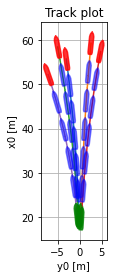

In [18]:
from src.visualization.plot import track_plot
fig,ax=plt.subplots()
#fig.set_size_inches(10,10)
for id,group in df.groupby(by='id'):
    track_plot(df=group, lpp=meta_data.lpp, x_dataset='x0', y_dataset='y0',  psi_dataset='psi', beam=meta_data.beam, ax=ax);

# Ship parameters

In [19]:
T_ = (meta_data.TA + meta_data.TF)/2
L_ = meta_data.lpp
m_ = meta_data.mass
rho_ = meta_data.rho
B_ = meta_data.beam
CB_ = m_/(T_*B_*L_*rho_)
I_z_ = m_*meta_data.KZZ**2

ship_parameters = {
        'T' : T_,
        'L' : L_,
        'CB' :CB_,
        'B' : B_,
        'rho' : rho_,
        'x_G' : 0,  # motions are expressed at CG
        'm' : m_,
        'I_z': I_z_, 
        'volume':meta_data.Volume,
    }

ps = prime_system.PrimeSystem(**ship_parameters)  # model

scale_factor = meta_data.scale_factor
ps_ship = prime_system.PrimeSystem(L=ship_parameters['L']*scale_factor, rho=meta_data['rho'])  # ship

In [20]:
ship_parameters

{'T': 0.2063106796116504,
 'L': 5.014563106796117,
 'CB': 0.45034232324249973,
 'B': 0.9466019417475728,
 'rho': 1000,
 'x_G': 0,
 'm': 441.0267843660858,
 'I_z': 693.124396594905,
 'volume': 0.4410267843660858}

# Brix parameters

In [21]:
def calculate_prime(row, ship_parameters):
    return run(function=row['brix_lambda'], inputs=ship_parameters)

mask = df_parameters['brix_lambda'].notnull()
df_parameters.loc[mask,'brix_prime'] = df_parameters.loc[mask].apply(calculate_prime, ship_parameters=ship_parameters, axis=1)
df_parameters['brix_prime'].fillna(0, inplace=True)

In [22]:
df_parameters['brix_prime']

Xudot               0.000179
Xvdot               0.000000
Xrdot               0.000000
Yudot               0.000000
Yvdot              -0.006109
Yrdot              -0.000303
Nudot               0.000000
Nvdot              -0.000128
Nrdot              -0.000299
Xu                  0.000000
Xv                  0.000000
Xr                  0.000000
Xdelta              0.000000
Xuu                 0.000000
Xuv                 0.000000
Xur                 0.000000
Xudelta             0.000000
Xvv                 0.000000
Xvr                 0.000000
Xvdelta             0.000000
Xrr                 0.000000
Xrdelta             0.000000
Xdeltadelta         0.000000
Xuuu                0.000000
Xuuv                0.000000
Xuur                0.000000
Xuudelta            0.000000
Xuvv                0.000000
Xuvr                0.000000
Xuvdelta            0.000000
Xurr                0.000000
Xurdelta            0.000000
Xudeltadelta        0.000000
Xvvv                0.000000
Xvvr          

In [23]:
df['Y_qs'] = run(Y_qs_lambda, inputs=ship_parameters, **df, **df_parameters['brix_prime'])
df['X_qs'] = run(X_qs_lambda, inputs=ship_parameters, **df, **df_parameters['brix_prime'])
df['N_qs'] = run(N_qs_lambda, inputs=ship_parameters, **df, **df_parameters['brix_prime'])

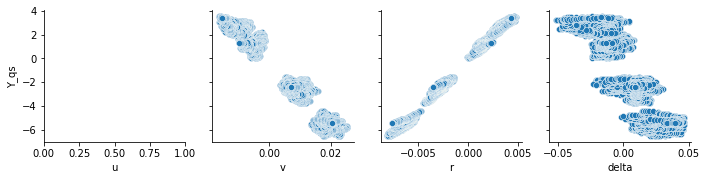

In [24]:
g = sns.PairGrid(df, x_vars=['u','v','r','delta'], y_vars=['Y_qs'])
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

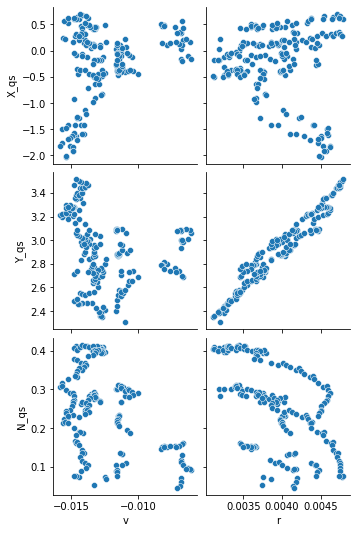

In [25]:
mask = df['delta'] <= df['delta'].quantile(q=0.01)
df_min = df.loc[mask].copy()
sns.pairplot(df_min, x_vars=['v','r'], y_vars=['X_qs','Y_qs','N_qs'])

<AxesSubplot:>

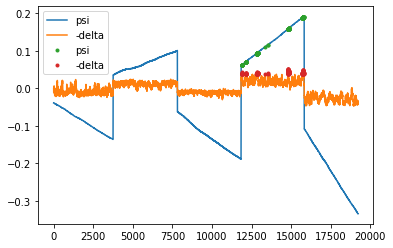

In [26]:
fig,ax=plt.subplots()
df.plot(y=['psi','-delta'], ax=ax)
df_min.plot(y=['psi','-delta'], style='.', ax=ax)

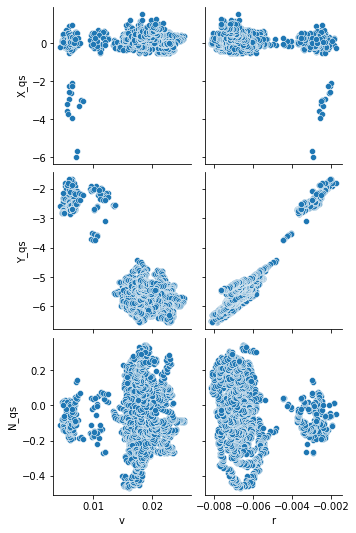

In [27]:
mask = df['delta'] >= df['delta'].quantile(q=0.85)
df_max = df.loc[mask].copy()
sns.pairplot(df_max, x_vars=['v','r'], y_vars=['X_qs','Y_qs','N_qs'])

<AxesSubplot:>

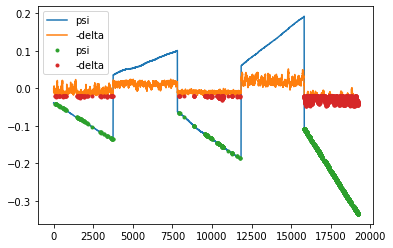

In [28]:
fig,ax=plt.subplots()
df.plot(y=['psi','-delta'], ax=ax)
df_max.plot(y=['psi','-delta'], style='.', ax=ax)

# Regression

## N

In [29]:
Math(vlatex(eq.N_qs_eq))

<IPython.core.display.Math object>

In [30]:
interesting = ['u','v','r','delta','X_qs','Y_qs','N_qs']
df_prime = ps.prime(df[interesting], U=df['V'])

In [31]:
N_ = sp.symbols('N_')
diff_eq_N = regression.DiffEqToMatrix(ode=eq.N_qs_eq.subs(N_qs,N_), 
                                      label=N_, base_features=[delta,u,v,r])

In [32]:
diff_eq_N.eq_beta

Eq(beta, Matrix([
[N_{deltadeltadelta}],
[            N_{rrr}],
[             N_{uu}],
[            N_{vvv}],
[    N_{rdeltadelta}],
[    N_{vdeltadelta}],
[        N_{rrdelta}],
[            N_{vrr}],
[        N_{uudelta}],
[            N_{uur}],
[            N_{uuv}],
[        N_{vvdelta}],
[            N_{vvr}],
[         N_{udelta}],
[             N_{ur}],
[             N_{uv}],
[        N_{vrdelta}],
[          N_{delta}],
[              N_{r}],
[              N_{v}]]))

In [33]:
Math(vlatex(diff_eq_N.eq_X))

<IPython.core.display.Math object>

In [34]:
diff_eq_N.eq_y

Eq(y, N_)

In [35]:
diff_eq_N.y_lambda

<function _lambdifygenerated(N_)>

In [36]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
def show_pred(X,y,results, label):
    
    display(results.summary())
    
    X_ = X
    y_ = y
    y_pred = results.predict(X_)
    
    prstd, iv_l, iv_u = wls_prediction_std(results, exog=X_, alpha=0.05)
    #iv_l*=-1 
    #iv_u*=-1
    
    fig,ax=plt.subplots()
    ax.plot(X_.index,y_, label='Numerical gradient from model test')
    ax.plot(X_.index,y_pred, '--', label='OLS')
    ax.set_ylabel(label)
    
    ax.fill_between(X_.index, y1=iv_l, y2=iv_u, zorder=-10, color='grey', alpha=0.5, label=r'5\% confidence')
    ax.legend();

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   N_qs   R-squared (uncentered):                   0.364
Model:                            OLS   Adj. R-squared (uncentered):              0.363
Method:                 Least Squares   F-statistic:                              646.0
Date:                Wed, 07 Jul 2021   Prob (F-statistic):                        0.00
Time:                        09:55:53   Log-Likelihood:                      2.2673e+05
No. Observations:               19222   AIC:                                 -4.534e+05
Df Residuals:                   19205   BIC:                                 -4.533e+05
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Ndeltadeltadelta    -0.0209      0.008     -2.560      0.010      -0.037      -0.005
Nrrr                 0.6187      0.123      5.036      0.000       0.378       0.859
Nuu              -7.429e-07   1.88e-08    -39.433      0.000    -7.8e-07   -7.06e-07
Nvvv                 3.8633      0.319     12.128      0.000       3.239       4.488
Nrdeltadelta        -0.1904      0.036     -5.318      0.000      -0.261      -0.120
Nvdeltadelta        -0.2256      0.044     -5.151      0.000      -0.311      -0.140
Nrrdelta            -0.6507      0.089     -7.281      0.000      -0.826      -0.475
Nvrr                 4.3624      0.559      7.797      0.000       3.266       5.459
Nuudelta          4126.8779    326.839     12.627      0.000    3486.244    4767.511
Nuur             -4580.4323    786.649     -5.823      0.000   -6122.334   -3038.531
Nuuv              -1.11e+04   1204.952     -9.208      0.000   -1.35e+04   -8733.349
Nvvdelta            -0.7345      0.120     -6.132      0.000      -0.969      -0.500
Nvvr                 5.7251      0.585      9.791      0.000       4.579       6.871
Nudelta          -8253.0205    653.672    -12.626      0.000   -9534.275   -6971.766
Nur               9155.1397   1573.363      5.819      0.000    6071.211    1.22e+04
Nuv               2.219e+04   2409.897      9.206      0.000    1.75e+04    2.69e+04
Nvrdelta            -1.2189      0.239     -5.092      0.000      -1.688      -0.750
Ndelta            4126.1425    326.833     12.625      0.000    3485.522    4766.763
Nr               -4574.7076    786.713     -5.815      0.000   -6116.735   -3032.680
Nv               -1.109e+04   1204.945     -9.205      0.000   -1.35e+04   -8729.499
==============================================================================
Omnibus:                        3.272   Durbin-Watson:                   0.035
Prob(Omnibus):                  0.195   Jarque-Bera (JB):                3.260
Skew:                          -0.032   Prob(JB):                        0.196
Kurtosis:                       3.007   Cond. No.                     4.87e+17
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 8.09e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

e:\dev\wpcc\venv\lib\site-packages\statsmodels\sandbox\regression\predstd.py:97: RuntimeWarning: invalid value encountered in sqrt
  predstd = np.sqrt(predvar)


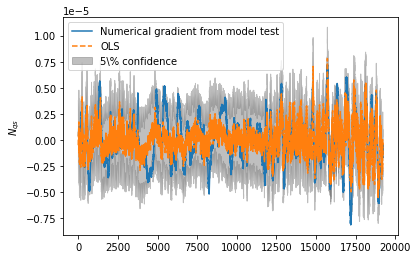

In [37]:
X = diff_eq_N.calculate_features(data=df_prime)
y = diff_eq_N.calculate_label(y=df_prime['N_qs'])

model_N = sm.OLS(y,X)
results_N = model_N.fit()

show_pred(X=X,y=y,results=results_N, label=r'$N_{qs}$')

## Y

In [38]:
Y_ = sp.symbols('Y_')
diff_eq_Y = regression.DiffEqToMatrix(ode=eq.Y_qs_eq.subs(Y_qs,Y_), 
                                      label=Y_, base_features=[delta,u,v,r])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Y_qs   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                          4.221e+05
Date:                Wed, 07 Jul 2021   Prob (F-statistic):                        0.00
Time:                        09:55:57   Log-Likelihood:                      1.8653e+05
No. Observations:               19222   AIC:                                 -3.730e+05
Df Residuals:                   19206   BIC:                                 -3.729e+05
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Yrrr           -22.6684      0.992    -22.851      0.000     -24.613     -20.724
Yuu          -5.536e-06   1.53e-07    -36.292      0.000   -5.84e-06   -5.24e-06
Yvvv           -40.2587      2.577    -15.621      0.000     -45.310     -35.207
Yrdeltadelta    -0.2081      0.231     -0.899      0.369      -0.662       0.246
Yvdeltadelta     0.0731      0.355      0.206      0.837      -0.622       0.768
Yrrdelta       -10.3931      0.704    -14.767      0.000     -11.773      -9.014
Yvrr           -98.5624      4.529    -21.762      0.000    -107.440     -89.685
Yuudelta     -2.048e+04   2605.999     -7.860      0.000   -2.56e+04   -1.54e+04
Yuur         -1.102e+05   6369.769    -17.294      0.000   -1.23e+05   -9.77e+04
Yuuv         -1.109e+05   9748.724    -11.378      0.000    -1.3e+05   -9.18e+04
Yvvdelta       -16.1273      0.967    -16.683      0.000     -18.022     -14.232
Yvvr           -87.3513      4.733    -18.454      0.000     -96.629     -78.073
Yudelta       4.098e+04   5211.958      7.863      0.000    3.08e+04    5.12e+04
Yur           2.204e+05   1.27e+04     17.300      0.000    1.95e+05    2.45e+05
Yuv           2.219e+05   1.95e+04     11.380      0.000    1.84e+05     2.6e+05
Yvrdelta       -33.8886      1.938    -17.483      0.000     -37.688     -30.089
Ydelta        -2.05e+04   2605.959     -7.866      0.000   -2.56e+04   -1.54e+04
Yr           -1.102e+05   6370.289    -17.306      0.000   -1.23e+05   -9.78e+04
Yv            -1.11e+05   9748.672    -11.383      0.000    -1.3e+05   -9.19e+04
==============================================================================
Omnibus:                      195.222   Durbin-Watson:                   0.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              262.573
Skew:                           0.146   Prob(JB):                     9.61e-58
Kurtosis:                       3.493   Cond. No.                     6.91e+17
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 4.03e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

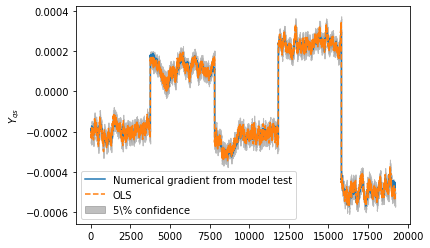

In [39]:
X = diff_eq_Y.calculate_features(data=df_prime)
y = diff_eq_Y.calculate_label(y=df_prime['Y_qs'])

model_Y = sm.OLS(y,X)
results_Y = model_Y.fit()

show_pred(X=X,y=y,results=results_Y, label=r'$Y_{qs}$')

## X

In [40]:
X_ = sp.symbols('X_')
diff_eq_X = regression.DiffEqToMatrix(ode=eq.X_qs_eq.subs(X_qs,X_), 
                                      label=X_, base_features=[delta,u,v,r])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   X_qs   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     41.75
Date:                Wed, 07 Jul 2021   Prob (F-statistic):          6.69e-114
Time:                        09:56:02   Log-Likelihood:             1.5969e+05
No. Observations:               19222   AIC:                        -3.193e+05
Df Residuals:                   19207   BIC:                        -3.192e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Xdeltadelta   -441.3930     74.097     -5.957      0.000    -586.630    -296.156
Xrr           -912.7442    358.865     -2.543      0.011   -1616.151    -209.337
Xuu          -4.679e+07   5.42e+06     -8.631      0.000   -5.74e+07   -3.62e+07
Xuuu          1.949e+07   2.26e+06      8.630      0.000    1.51e+07    2.39e+07
Xvv           -1.17e+07   1.35e+06     -8.634      0.000   -1.44e+07   -9.04e+06
Xudeltadelta   441.4356     74.103      5.957      0.000     296.187     586.684
Xurr           912.9740    358.895      2.544      0.011     209.508    1616.440
Xuvv          7.798e+06   9.03e+05      8.634      0.000    6.03e+06    9.57e+06
Xrdelta       -243.7525    244.551     -0.997      0.319    -723.094     235.589
Xvdelta        812.4373    330.467      2.458      0.014     164.692    1460.182
Xvr          -2405.9098   1088.975     -2.209      0.027   -4540.396    -271.424
Xurdelta       243.7347    244.569      0.997      0.319    -235.642     723.112
Xvrdelta         0.0198      0.188      0.105      0.916      -0.349       0.388
Xuvdelta      -812.5839    330.492     -2.459      0.014   -1460.377    -164.791
Xuvr          2406.7040   1089.062      2.210      0.027     272.047    4541.361
Xu            2.729e+07   3.16e+06      8.631      0.000    2.11e+07    3.35e+07
==============================================================================
Omnibus:                    20476.471   Durbin-Watson:                   0.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1347813.618
Skew:                          -5.496   Prob(JB):                         0.00
Kurtosis:                      42.522   Cond. No.                     1.35e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.15e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

e:\dev\wpcc\venv\lib\site-packages\statsmodels\sandbox\regression\predstd.py:97: RuntimeWarning: invalid value encountered in sqrt
  predstd = np.sqrt(predvar)


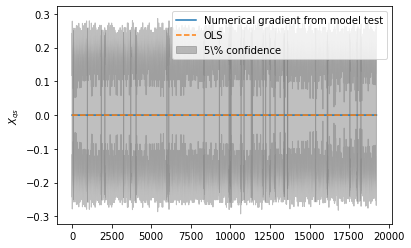

In [41]:
X = diff_eq_X.calculate_features(data=df_prime)
y = diff_eq_X.calculate_label(y=df_prime['X_qs'])

model_X = sm.OLS(y,X)
results_X = model_X.fit()

show_pred(X=X,y=y,results=results_X, label=r'$X_{qs}$')

In [42]:
results_summary_X = regression.results_summary_to_dataframe(results_X)
results_summary_Y = regression.results_summary_to_dataframe(results_Y)
results_summary_N = regression.results_summary_to_dataframe(results_N)

## Add the regressed parameters
Hydrodynamic derivatives that depend on acceleration cannot be obtained from the VCT regression. They are however essential if a time simulation should be conducted. These values have then been taken from Brix semi empirical formulas for the simulations below.

In [43]:
df_parameters_all = df_parameters.copy()
for other in [results_summary_X, results_summary_Y, results_summary_N]:
    df_parameters_all = df_parameters_all.combine_first(other)

df_parameters_all.rename(columns={'coeff':'regressed'}, inplace=True)
df_parameters_all.drop(columns=['brix_lambda'], inplace=True)

df_parameters_all['prime'] = df_parameters_all['regressed'].combine_first(df_parameters_all['brix_prime'])  # prefer regressed

In [44]:
df_parameters_all

,$P_{value}$,$conf_{higher}$,$conf_{lower}$,brix,brix_prime,regressed,coord,dof,state,symbol,prime
Ndelta,2.154833e-36,4.766763e+03,3.485522e+03,NaN,0.000000,4.126143e+03,delta,N,,N_{delta},4.126143e+03
Ndeltadelta,NaN,NaN,NaN,NaN,0.000000,NaN,deltadelta,N,,N_{deltadelta},0.000000e+00
Ndeltadeltadelta,1.047192e-02,-4.902022e-03,-3.692957e-02,NaN,0.000000,-2.091580e-02,deltadeltadelta,N,,N_{deltadeltadelta},-2.091580e-02
Nr,6.161012e-09,-3.032680e+03,-6.116735e+03,-pi*T**2*(0.039*B/T - 0.56*B/L + 0.25)/L**2,-0.001719,-4.574708e+03,r,N,,N_{r},-4.574708e+03
Nrdelta,NaN,NaN,NaN,NaN,0.000000,NaN,rdelta,N,,N_{rdelta},0.000000e+00
Nrdeltadelta,1.062040e-07,-1.202157e-01,-2.605691e-01,NaN,0.000000,-1.903924e-01,rdeltadelta,N,,N_{rdeltadelta},-1.903924e-01
Nrdot,NaN,NaN,NaN,-pi*T**2*(0.017*B*CB/T - 0.33*B/L + 0.08333333...,-0.000299,NaN,r,N,dot,N_{\dot{r}},-2.986748e-04
Nrr,NaN,NaN,NaN,NaN,0.000000,NaN,rr,N,,N_{rr},0.000000e+00
Nrrdelta,3.435729e-13,-4.754979e-01,-8.258054e-01,NaN,0.000000,-6.506516e-01,rrdelta,N,,N_{rrdelta},-6.506516e-01
Nrrr,4.801818e-07,8.594864e-01,3.778692e-01,NaN,0.000000,6.186778e-01,rrr,N,,N_{rrr},6.186778e-01


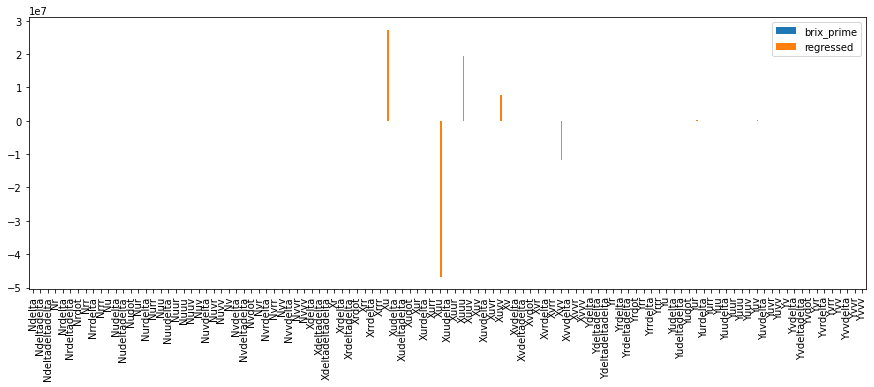

In [45]:
fig,ax=plt.subplots()
fig.set_size_inches(15,5)
df_parameters_all.plot.bar(y=['brix_prime','regressed'], ax=ax);

# Simulate captive

In [46]:
X_qs_lambda = lambdify(eq.X_qs_eq.rhs.subs(subs))
Y_qs_lambda = lambdify(eq.Y_qs_eq.rhs.subs(subs))
N_qs_lambda = lambdify(eq.N_qs_eq.rhs.subs(subs))

In [47]:
df_prime['X_qs_pred'] = run(function=X_qs_lambda, inputs=df_prime, **df_parameters_all['prime'])
df_prime['Y_qs_pred'] = run(function=Y_qs_lambda, inputs=df_prime, **df_parameters_all['prime'])
df_prime['N_qs_pred'] = run(function=N_qs_lambda, inputs=df_prime, **df_parameters_all['prime'])


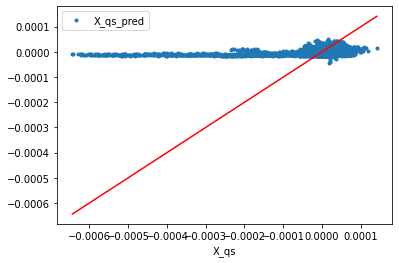

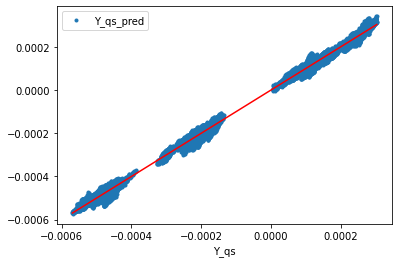

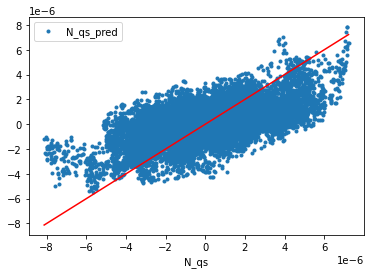

In [48]:
for key in ['X_qs','Y_qs','N_qs']:
    fig,ax=plt.subplots()
    df_prime.plot(x=key, y=f'{key}_pred',style='.', ax=ax)
    ax.plot([df_prime[key].min(), df_prime[key].max()], [df_prime[key].min(), df_prime[key].max()], 'r-')

# Simulation

In [49]:
df_ = df.copy()

def simulate(df_):

    t = df_.index
    control = df_[['delta']]
    #control = {'delta':0,}
    
    df_0 = df_.iloc[0:100].median(axis=0)
    y0 = {
        'u' : df_0['u'], 
        'v' : df_0['v'],
        'r' : df_0['r'],
        'x0' : df_0['x0'],
        'y0' : df_0['y0'],
        'psi' : df_0['psi'],
        }
    
    #solution = model.simulate(y0=y0, t=t, df_parameters=df_parameters, df_ship_parameters=df_ship_parameters, control=control, rtol=1e-3, atol=1e-3)
    simulation = model.
    solution = model.simulation.simulate(y0=y0, t=t, df_parameters=df_parameters_all, ship_parameters=ship_parameters, control=control)
    
    columns = list(y0.keys())
    df_result_prime = pd.DataFrame(data=solution.y.T, columns=columns)
    df_result_prime.index=t[0:len(df_result_prime)]
    
    U_ = np.sqrt(df_0['u']**2 + df_0['v']**2)
    df_result = ps.unprime(values=df_result_prime, U=U_)
    df_result['beta'] = -np.arctan2(df_result['v'],df_result['u'])
    return df_result


In [50]:
df_result = pd.DataFrame()
for id,group in df.groupby(by='id'):
    
    df_ = group.set_index('t')
    df_result_ = simulate(df_)
    df_result_['id'] = id
    df_result_['t'] = df_result_.index
    df_result = df_result.append(df_result_, ignore_index=True)
    

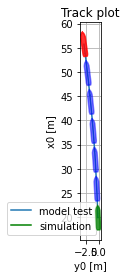

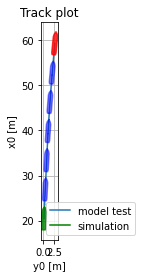

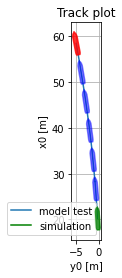

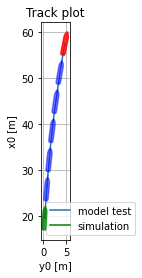

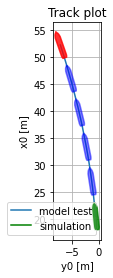

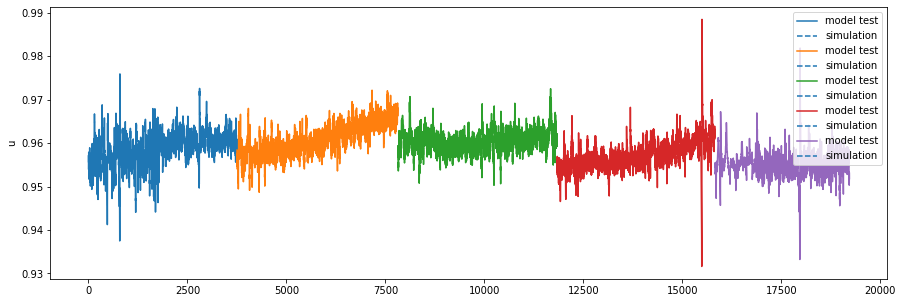

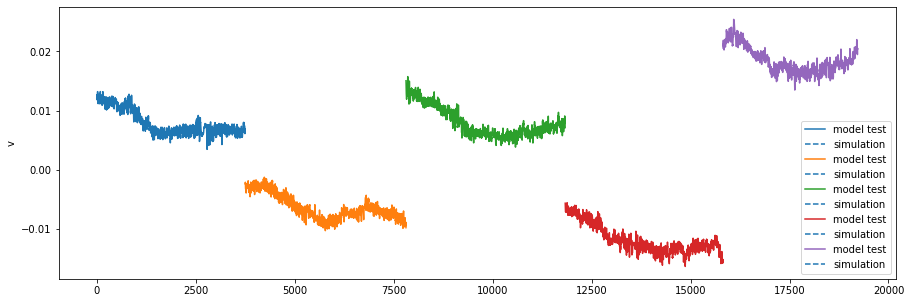

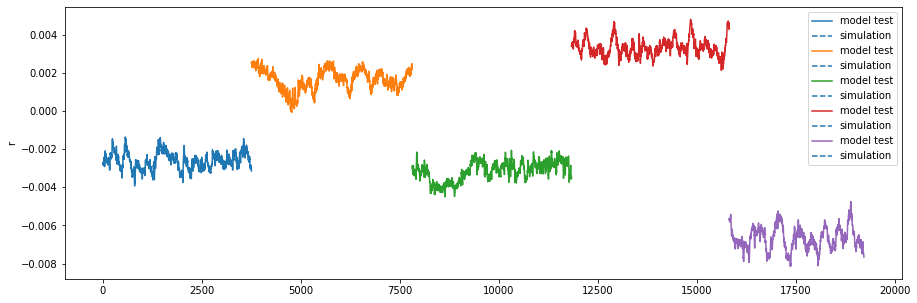

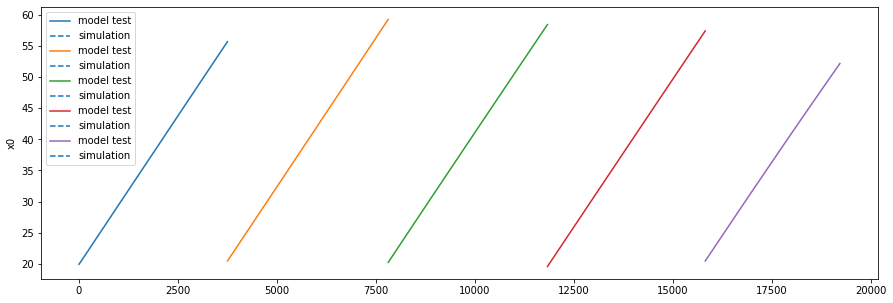

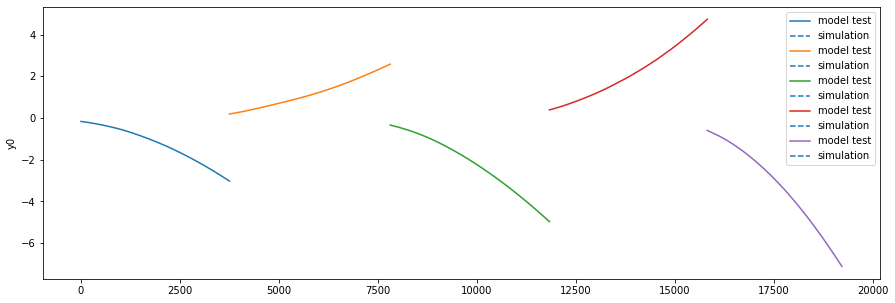

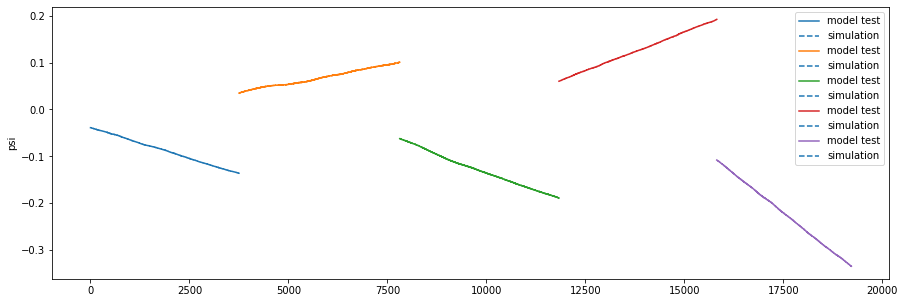

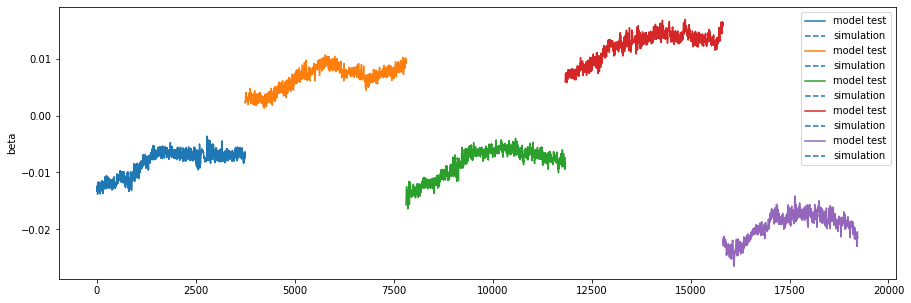

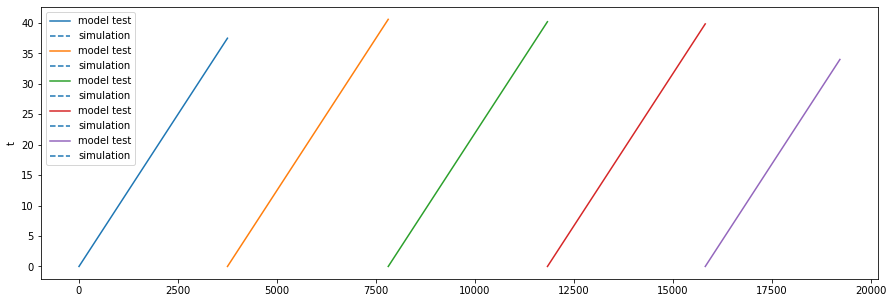

In [51]:
groups = df.groupby(by='id')
for id,group in df_result.groupby(by='id'):
    fig,ax=plt.subplots()
    track_plot(df=groups.get_group(id), lpp=ship_parameters['L'], beam=ship_parameters['B'],ax=ax, label='model test')
    track_plot(df=group, lpp=ship_parameters['L'], beam=ship_parameters['B'],ax=ax, label='simulation', color='green')
    ax.legend()

for key in df_result:
    
    if key=='id':
        continue
    
    fig,ax = plt.subplots()
    fig.set_size_inches(15,5)
        
    for id,group in df_result.groupby(by='id'):
        plot = groups.get_group(id).plot(y=key, label='model test', ax=ax)
        
        color = plot.lines[0].get_color()
        group.plot(y=key, label='simulation', color=color, style='--', ax=ax)
        ax.set_ylabel(key)

